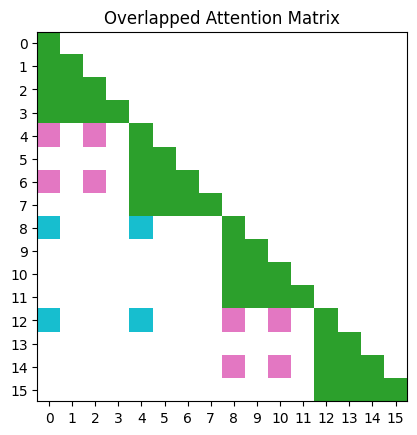

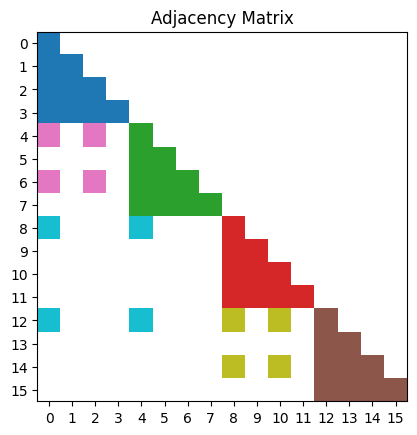

In [8]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


N = 16 # Sequence length
w0 = 4 # Initial window size
r0 = 1 # Initial stride size
k = 3 # Number of different (w,r) pairs
alpha = 2 # Geometric progression factor
# Generate the w_seq as a geometric progression
w_seq = [w0 * alpha ** i for i in range(k)]
# Generate the r_seq as a geometric progression
r_seq = [r0 * alpha ** i for i in range(k)]

colors = ['#FFFFFF', '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

assert w_seq[-1] == N, f"The last element of w_seq must be N, but it is {w_seq[-1]}"

k = len(w_seq) # Number of different (w,r) pairs

def get_indices_for_configuration(w, r):
    # Split the whole sequence in multiple "segments" of length w
    num_segments = N // w
    for segment_index in range(num_segments):
        segment_start_index = segment_index * w
        segment_end_index = segment_start_index + w 
        # Select the indices in the segment with a stride of r
        indices = np.arange(segment_start_index, segment_end_index, r)
        yield indices

# Create a grid of size (N, N) with zeros
matrix = np.zeros((N, N))
adj_matrix = np.zeros((N, N))
adj_list = defaultdict(set)

group_index = 0 # Indicates that nodes belonging to the same segment have an edge connecting them

# Color each (w,r) pair with a different color
for i, (w, r) in enumerate(zip(w_seq, r_seq)):
    indices = get_indices_for_configuration(w, r)
    for j, segment_indices in enumerate(indices):
        group_index += 1
        for index1 in segment_indices:
            for index2 in segment_indices:
                if matrix[index1, index2] == 0 and index1 >= index2:
                    adj_list[index1].add(index2.item())
                    adj_list[index2].add(index1.item())
                    adj_matrix[index1, index2] = group_index
                    matrix[index1, index2] = i + 1

# Plot is useless for big sequence lengths
if N < 100:
        # Plot the matrix and for each position use the color corresponding to the value in the matrix taken from the colors array
        plt.imshow(matrix, cmap=ListedColormap(colors), interpolation='nearest')
        plt.xticks(np.arange(0, N, 1.0))
        plt.yticks(np.arange(0, N, 1.0))    
        plt.title('Overlapped Attention Matrix')
        plt.show()

        plt.imshow(adj_matrix, cmap=ListedColormap(colors), interpolation='nearest')
        plt.xticks(np.arange(0, N, 1.0))
        plt.yticks(np.arange(0, N, 1.0))
        plt.title('Adjacency Matrix')
        plt.show()

        

In [9]:
START_NODE = 0
DISPLAY_ALL_PATHS = False
VERIFY_MAX_DISTANCE = True

distances = {}
paths = {}

# Perform a very ugly, unoptimized BFS
visited = set([START_NODE])
queue = [(START_NODE, 0, [])]
while queue:
    node, distance, path = queue.pop(0)
    distances[node] = distance
    paths[node] = path
    for neighbor in adj_list[node]:
        if neighbor not in visited:
            visited.add((neighbor))
            queue.append((neighbor, distance+1, path + [neighbor]))

# Display the shortest path from the start node to every other node
if DISPLAY_ALL_PATHS:
    for destination_node in range(0, N):
        print(f"Distance from {START_NODE} to {destination_node}: {distances[destination_node]}")
        print(f"Path: {paths[destination_node]}")

# Check that every node is reachable from the start node
assert len(distances) == N, f"Expected {N} distances, but got {len(distances)}"

# Check that the maximum distance grows like the log(N)
if VERIFY_MAX_DISTANCE:
    max_distance = max(distances.values())
    print(f"Max distance: {max_distance}. Log(N) = {np.log(N)}")



Max distance: 2. Log(N) = 2.772588722239781
